# 📘 Project: Melanoma Detection using EfficientNet

**Description:** End-to-end Deep Learning project for skin cancer classification.



## 1. Problem Definition and Data Collection
**Objective:** Build a binary classification model to detect Melanoma (Malignant) vs Benign skin lesions.

**Dataset Structure:** The data consists of images sized 224x224, divided into `train` and `test` folders.



## 2. Data Cleaning and Analysis
Checking libraries, setting up the device (GPU/CPU), and visualizing sample data.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import random
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

TRAIN_DIR = r"C:\Users\DELL\Desktop\stude pthon\archive (2)\train"
TEST_DIR  = r"C:\Users\DELL\Desktop\stude pthon\archive (2)\test"

Using device: cuda


## 3. Dataset Visualization
random Samples for Data Integrity Check
Visualizing random samples from train and test sets to ensure data integrity before training.*

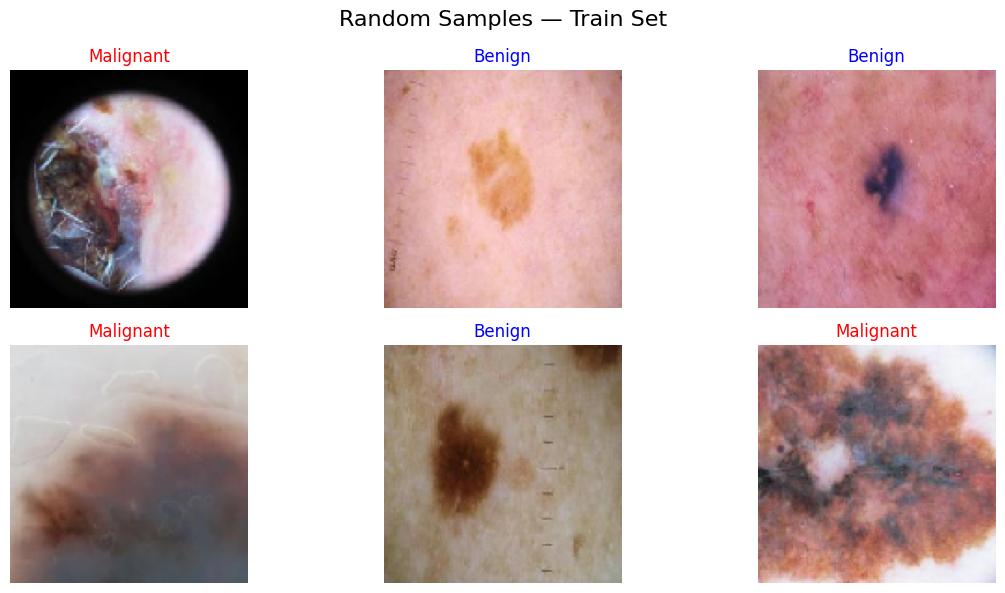

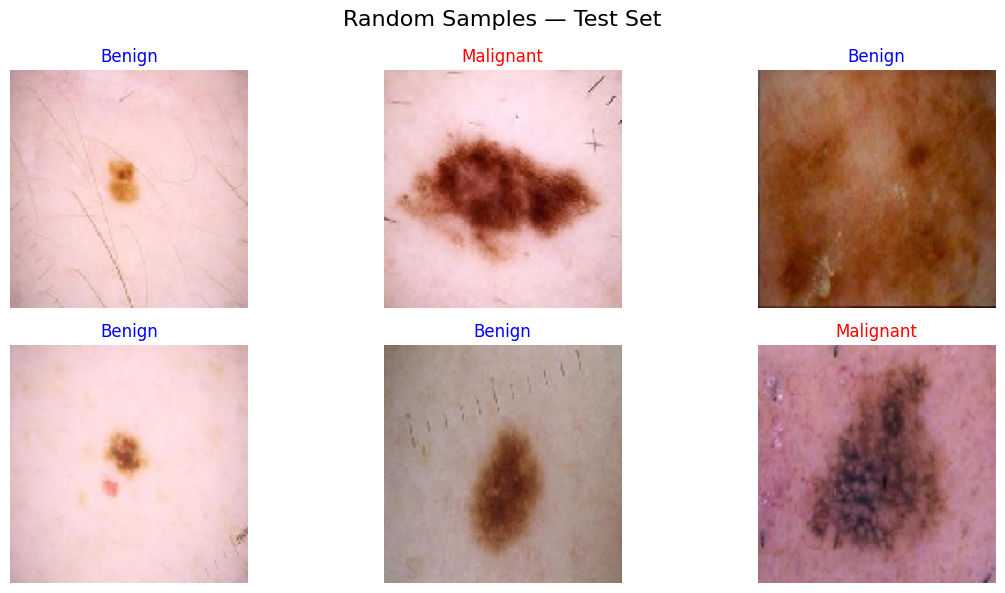

In [ ]:
DATA_DIR = Path(r"C:\Users\DELL\Desktop\stude pthon\archive (2)")
SPLITS = ['train', 'test']
CLASSES = ['Benign', 'Malignant']

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

def load_image(path):
    return transform(Image.open(path).convert("RGB")).permute(1, 2, 0)

def get_images(dir):
    return [p for p in dir.glob("*") if p.suffix.lower() in (".jpg", ".png", ".jpeg")]

def show_random_grid():
    for split in SPLITS:
        images = []
        for cls in CLASSES:
            cls_dir = DATA_DIR / split / cls
            images += [(p, cls) for p in get_images(cls_dir)]

        samples = random.sample(images, min(6, len(images)))

        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        
        for ax, (img_path, cls) in zip(axes.flatten(), samples):
            ax.imshow(load_image(img_path))
            ax.set_title(cls, color="blue" if cls == "Benign" else "red")
            ax.axis("off")

        fig.suptitle(f"Random Samples — {split.capitalize()} Set", fontsize=16)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    show_random_grid()



## 4. Feature Engineering
We apply **Data Augmentation** (Flip, Rotation, ColorJitter) to the training set to improve generalization and avoid overfitting.


Training Samples: 11879
Classes: ['Benign', 'Malignant']


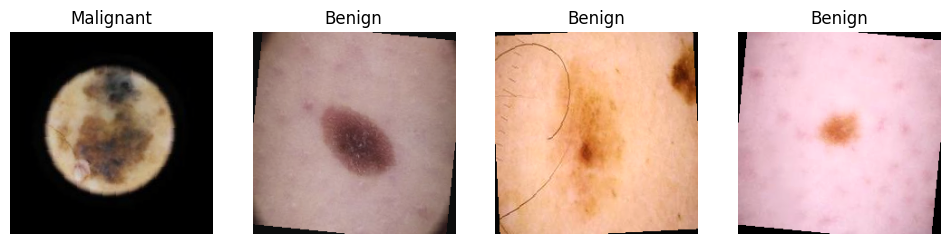

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Training Samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")

def show_sample_images(loader, classes):
    dataiter = iter(loader)
    images, labels = dataiter.next()
    
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        img = images[i].numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()
show_sample_images(train_loader, train_dataset.classes)



## 5. Model Design
We use **EfficientNet_B0** via Transfer Learning. We modify the classifier head to include Dropout and BatchNorm for better stability.


In [ ]:
def get_model(device, num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    num_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.GELU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    )
    return model.to(device)

model = get_model(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


## 6. Model Training
Training loop using **OneCycleLR** scheduler and **AdamW** optimizer. We save the best model based on validation accuracy.


In [ ]:
LR = 3e-4
EPOCHS = 15

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.2
)

best_acc = 0.0
print("Starting training...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(train_dataset)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_dataset)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "final_best_melanoma_model.pth")
        print(f">> Saved Best Model: {best_acc:.4f}")

Starting training...

Epoch 1/15
------------------------------


Val: 100%|██████████| 63/63 [00:13<00:00,  4.77it/s]


Train Acc: 0.7823 | Val Acc: 0.9175
>> Saved Best Model: 0.9175

Epoch 2/15
------------------------------


Val: 100%|██████████| 63/63 [00:14<00:00,  4.42it/s]


Train Acc: 0.8797 | Val Acc: 0.9290
>> Saved Best Model: 0.9290

Epoch 3/15
------------------------------


Val: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]


Train Acc: 0.9058 | Val Acc: 0.9330
>> Saved Best Model: 0.9330

Epoch 4/15
------------------------------


Val: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]


Train Acc: 0.9189 | Val Acc: 0.9250

Epoch 5/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  5.87it/s]


Train Acc: 0.9318 | Val Acc: 0.9480
>> Saved Best Model: 0.9480

Epoch 6/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]


Train Acc: 0.9425 | Val Acc: 0.9430

Epoch 7/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  5.97it/s]


Train Acc: 0.9537 | Val Acc: 0.9510
>> Saved Best Model: 0.9510

Epoch 8/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  6.18it/s]


Train Acc: 0.9628 | Val Acc: 0.9555
>> Saved Best Model: 0.9555

Epoch 9/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s]


Train Acc: 0.9692 | Val Acc: 0.9545

Epoch 10/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s]


Train Acc: 0.9778 | Val Acc: 0.9615
>> Saved Best Model: 0.9615

Epoch 11/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  6.18it/s]


Train Acc: 0.9859 | Val Acc: 0.9630
>> Saved Best Model: 0.9630

Epoch 12/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s]


Train Acc: 0.9915 | Val Acc: 0.9640
>> Saved Best Model: 0.9640

Epoch 13/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]


Train Acc: 0.9939 | Val Acc: 0.9610

Epoch 14/15
------------------------------


Val: 100%|██████████| 63/63 [00:10<00:00,  5.89it/s]


Train Acc: 0.9927 | Val Acc: 0.9600

Epoch 15/15
------------------------------


Val: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]

Train Acc: 0.9944 | Val Acc: 0.9560



## 7. Model Testing and Inference
Loading the best model and testing on the test images.


Using device: cuda


C:\Users\DELL\AppData\Local\Temp\ipykernel_17252\4039664001.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE

Model loaded successfully from: C:\Users\DELL\Desktop\final_best_melanoma_model.pth


Testing: 100%|██████████| 125/125 [00:05<00:00, 22.79it/s]



⭐ FINAL TEST ACCURACY: 96.40% (1928/2000)

✅ Weighted F1 Score: 0.9640

--- Classification Report ---
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96      1000
   Malignant       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



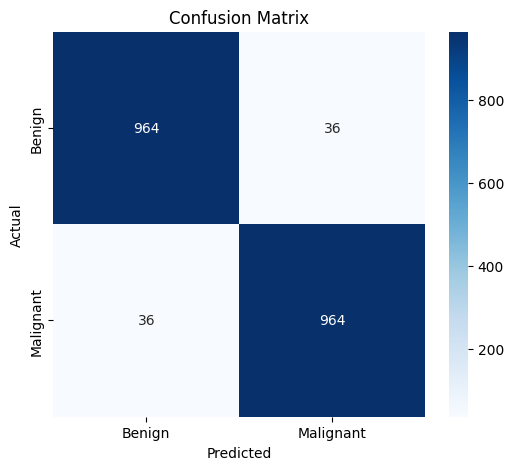

In [ ]:
BASE_DIR = Path(__file__).parent
MODEL_PATH = BASE_DIR / "final_best_melanoma_model.pth"
IMG_SIZE = 224
BATCH_SIZE = 16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def get_efficientnet_model(device):
    model = models.efficientnet_b0(weights=None)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.GELU(),
        nn.Dropout(0.4),
        nn.Linear(512, 2)
    )
    return model.to(device)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_dataset.classes

if __name__ == '__main__':
    model = get_efficientnet_model(DEVICE)
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded successfully from: {MODEL_PATH}")

    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Accuracy
    correct = sum([p==l for p,l in zip(all_preds, all_labels)])
    total = len(all_labels)
    accuracy = correct / total
    print("\n" + "="*50)
    print(f"⭐ FINAL TEST ACCURACY: {accuracy*100:.2f}% ({correct}/{total})")
    print("="*50)

    # Calculate Confusion Matrix و F1-score
    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n✅ Weighted F1 Score: {f1:.4f}")
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Draw Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


## 8. Image Prediction 

🖼️ Image: C:\Users\DELL\Desktop\stude pthon\data\data\train\benign\900.jpg
✅ Predicted Class: Benign

🔹 Scores for each class:
Benign: 99.58%
Malignant: 0.42%


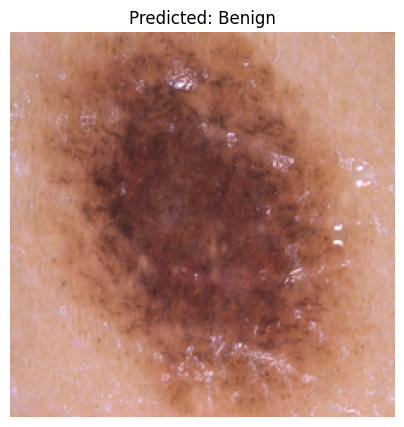

In [ ]:
def predict_single_image_with_scores(image_path, model, transform, class_names, device):
    
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  

    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  
        _, pred = torch.max(outputs, 1)
    
    predicted_class = class_names[pred.item()]

    print(f"🖼️ Image: {image_path}")
    print(f"✅ Predicted Class: {predicted_class}")
    print("\n🔹 Scores for each class:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {probs[0][i].item()*100:.2f}%")
    
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

SINGLE_IMAGE_PATH = r"C:\Users\DELL\Desktop\stude pthon\data\data\train\benign\900.jpg"
predict_single_image_with_scores(SINGLE_IMAGE_PATH, model, transform, class_names, DEVICE)